<a href="https://colab.research.google.com/github/samtbeardsley/Food_Porn/blob/master/03_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 6.8MB/s 


In [ ]:
import numpy as np
import pandas as pd
import os
from skimage import io
from skimage import color
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping
from keras import layers
from keras import models
from keras.models import load_model
import kerastuner as kt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Preparing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = 'drive/My Drive/FoodPorn/Images'

batch_size = 32
img_height = 224
img_width = 224

In [ ]:
image_count = 41537
seed = 23

list_ds = tf.data.Dataset.list_files(f'{data_dir}/*/*', shuffle=False)
list_ds = list_ds.shuffle(image_count, seed=seed, reshuffle_each_iteration=False)

In [ ]:
train_size = 4500
val_size = 1000
test_size = 1000

# hyper parameter selection datasets
dataset = list_ds.take(train_size + val_size)
train_ds = dataset.take(train_size) 
val_ds = dataset.skip(train_size)

# final model training dataset
full_ds = list_ds.skip(train_size + val_size)
full_ds = full_ds.take(8500)
full_train_ds = full_ds.concatenate(train_ds)

# final model test dataset
test_ds = list_ds.skip(len(full_train_ds))
test_ds = test_ds.take(test_size)

In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
class_names = ['FP', 'SFP']

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_dataset = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_dataset = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
full_train_ds = full_train_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
def configure_for_performance(ds, shuffle=True):
  ds = ds.cache()
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  if shuffle == True:
    ds = ds.shuffle(buffer_size=1000)
  return ds

train_dataset = configure_for_performance(train_dataset)
val_dataset = configure_for_performance(val_dataset, shuffle = False)
test_dataset = configure_for_performance(test_dataset, shuffle = False)
full_train_ds = configure_for_performance(full_train_ds)

# Model Selection

I'll use transfer learning to test three pretrained models: ResNet50, VGG16, and InceptionV3. As part of the model selection I'll use [Keras Tuner's](https://www.tensorflow.org/tutorials/keras/keras_tuner) Hyperband algorithm to find the best dropout rate and learning rate for these models. This will train on 4,500 images.

## VGG16

In [ ]:
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_vgg.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
def create_vgg(hp):
  inputs = keras.Input(shape=(224, 224, 3))
  
  # rescale to range [0,1]
  x = keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

  # create base model & fix weights
  x = base_vgg(x, training=False)

  # create trainable layers
  x = keras.layers.GlobalAveragePooling2D()(x)
  
  # Tune the dropout rate
  # Choose an optimal values from 0.0, to 0.5 in increments of 0.1
  hp_dropout = hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)
  x = keras.layers.Dropout(hp_dropout)(x)
  outputs = keras.layers.Dense(1, activation='sigmoid')(x)

  VGG16_model = keras.Model(inputs, outputs)

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.1, 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4]) 


  VGG16_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

  return VGG16_model

In [ ]:
vgg_tuner = kt.Hyperband(
    create_vgg,
    objective='val_accuracy',
    max_epochs=10,
    seed=23,
    hyperband_iterations=2,
    directory= 'drive/My Drive/FoodPorn/Hyperband',
    project_name='vgg_hyperband_trial',
    overwrite=True)

vgg_tuner.search(train_dataset,
             validation_data=val_dataset,
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Trial 30 Complete [00h 01m 17s]
val_accuracy: 0.7720000147819519

Best val_accuracy So Far: 0.7770000100135803
Total elapsed time: 00h 26m 53s
INFO:tensorflow:Oracle triggered exit


In [ ]:
vgg_tuner.results_summary()

Results summary
Results in drive/My Drive/FoodPorn/Hyperband/vgg_hyperband_trial
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout: 0.30000000000000004
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 6b8ca2f8c316f0ebd5b9b07307938286
Score: 0.7770000100135803
Trial summary
Hyperparameters:
dropout: 0.1
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7770000100135803
Trial summary
Hyperparameters:
dropout: 0.30000000000000004
learning_rate: 0.01
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.7749999761581421
Trial summary
Hyperparameters:
dropout: 0.1
learning_rate: 0.1
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 812c53e3cd104eb18b1a982859c27c1c
Score: 0.7739999890327454
Trial summary
Hyperparameters:
dropout: 0.0
learning_rate: 0.001
tuner/e

## ResNet50

In [ ]:
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_resnet.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
def create_resnet(hp):
  inputs = keras.Input(shape=(224, 224, 3))

  # rescale to range [0,1]
  x = keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

  # create base model & fix weights
  x = base_resnet(inputs, training=False)

  # create trainable layers
  x = keras.layers.GlobalAveragePooling2D()(x)
  # Tune the dropout rate
  # Choose an optimal values from 0.1, 0.2, 0.3, 0.4, or 0.5
  hp_dropout = hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)
  x = keras.layers.Dropout(hp_dropout)(x)  # Regularize with dropout
  
  outputs = keras.layers.Dense(1, activation='sigmoid')(x)

  ResNet50_model = keras.Model(inputs, outputs)

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.1, 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4]) 


  ResNet50_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

  return ResNet50_model

In [ ]:
resnet_tuner = kt.Hyperband(
    create_resnet,
    objective='val_accuracy',
    max_epochs=10,
    seed=23,
    hyperband_iterations=2,
    directory= 'drive/My Drive/FoodPorn/Hyperband',
    project_name='resnet_hyperband_trial',
    overwrite=True)

resnet_tuner.search(train_dataset,
             validation_data=val_dataset,
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Trial 30 Complete [00h 01m 14s]
val_accuracy: 0.8159999847412109

Best val_accuracy So Far: 0.8259999752044678
Total elapsed time: 00h 15m 26s
INFO:tensorflow:Oracle triggered exit


In [ ]:
resnet_tuner.results_summary()

Results summary
Results in drive/My Drive/FoodPorn/Hyperband/resnet_hyperband_trial
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout: 0.4
learning_rate: 0.001
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.8259999752044678
Trial summary
Hyperparameters:
dropout: 0.1
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: b0a346854d262aa7c0b5edd3c536f035
Score: 0.8240000009536743
Trial summary
Hyperparameters:
dropout: 0.30000000000000004
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 21f28ee99bf0f6e81363b2b073c02cf1
Score: 0.8199999928474426
Trial summary
Hyperparameters:
dropout: 0.30000000000000004
learning_rate: 0.001
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: c079a098652d29b33e5a710838a2e384
Score: 0.8180000185966492
Trial summary
Hy

## InceptionV3

In [ ]:
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_inception.trainable = False

87916544/87910968 [==============================] - 3s 0us/step


In [ ]:
def create_inception(hp):
  inputs = keras.Input(shape=(224, 224, 3))

  # rescale to range [0,1]
  x = keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

  # create base model & fix weights
  x = base_inception(inputs, training=False)

  # create trainable layers
  x = keras.layers.GlobalAveragePooling2D()(x) 
  # Tune the dropout rate
  # Choose an optimal values from 0.1, 0.2, 0.3, 0.4, or 0.5
  hp_dropout = hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)
  x = keras.layers.Dropout(hp_dropout)(x)  # Regularize with dropout
  
  outputs = keras.layers.Dense(1, activation='sigmoid')(x)
  Inception_model = keras.Model(inputs, outputs)

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.1, 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4]) 


  Inception_model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

  return Inception_model

In [ ]:
inception_tuner = kt.Hyperband(
    create_inception,
    objective='val_accuracy',
    max_epochs=10,
    seed=23,
    hyperband_iterations=2,
    directory= 'drive/My Drive/FoodPorn/Hyperband',
    project_name='inception_hyperband_trial',
    overwrite=True)

inception_tuner.search(train_dataset,
             validation_data=val_dataset,
             epochs=10,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Trial 30 Complete [00h 01m 08s]
val_accuracy: 0.656000018119812

Best val_accuracy So Far: 0.6949999928474426
Total elapsed time: 00h 14m 35s
INFO:tensorflow:Oracle triggered exit


In [ ]:
inception_tuner.results_summary()

Results summary
Results in drive/My Drive/FoodPorn/Hyperband/inception_hyperband_trial
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout: 0.4
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 9e585fc6b190478915c6d784bb3c33f1
Score: 0.6949999928474426
Trial summary
Hyperparameters:
dropout: 0.5
learning_rate: 0.1
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6800000071525574
Trial summary
Hyperparameters:
dropout: 0.5
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.6769999861717224
Trial summary
Hyperparameters:
dropout: 0.4
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6759999990463257
Trial summary
Hyperparameters:
dropout: 0.2
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score:

## Results

After conducting the Hyperband trials the ResNet50 pretrained network performed the best with a 0.8260 validation accuracy.

#### Parameters Evaluated

| Parameter | Values |
| ---- | ---- |
| Dropout Rate | 0.0, 0.1, 0.2, 0.3, 0.4, 0.5 |
|Learning Rate | 0.1, 0.01, 0.001, 0.0001 |

#### Results

| Pretrained Network | Best Parameters | Validation Accuracy |
| ---- | ---- | ---- |
| VGG16 | Dropout: 0.3, Learning Rate: 0.01 | 0.7770 | 
| ResNet50 | Dropout: 0.4, Learning Rate: 0.001 | 0.8260 |
| InceptionV3 | Dropout: 0.4, Learning Rate: 0.001 | 0.6950 |


# Model Tuning

Now that I've selected the ResNet50 pretrained model and parameters, I'll train using the best hyperparameters with 13,000 images and allow for increased training time. Finally, I'll unfreeze the bottom layers to perform a fine tuning pass with a lower learning rate.

In [ ]:
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_resnet.trainable = False

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))

# rescale to range [0,1]
x = keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# create base model & fix weights
x = base_resnet(inputs, training=False)

# create trainable layers
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.4)(x)  # Regularize with dropout
  
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

resnet = keras.Model(inputs, outputs)

resnet.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

In [ ]:
resnet.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


## Base Model Training

In [ ]:
initial_epochs = 1000

# stop training if val accuracy does not improve after 20 epochs
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  patience=20)
# save best model with lowest loss
checkpoint_path = 'drive/My Drive/FoodPorn/Models/resnet.h5'
mc =  keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)

history = resnet.fit(full_train_ds,
                     epochs=initial_epochs,
                     validation_data=val_dataset,
                     callbacks=[early_stop, mc])

Epoch 1/1000
406/407 [============================>.] - ETA: 0s - loss: 0.5718 - accuracy: 0.7260
Epoch 00001: val_loss improved from inf to 0.41062, saving model to drive/My Drive/FoodPorn/Models/resnet.h5
407/407 [==============================] - 20s 49ms/step - loss: 0.5719 - accuracy: 0.7258 - val_loss: 0.4106 - val_accuracy: 0.8210
Epoch 2/1000
406/407 [============================>.] - ETA: 0s - loss: 0.4802 - accuracy: 0.7771
Epoch 00002: val_loss improved from 0.41062 to 0.40660, saving model to drive/My Drive/FoodPorn/Models/resnet.h5
407/407 [==============================] - 17s 43ms/step - loss: 0.4803 - accuracy: 0.7770 - val_loss: 0.4066 - val_accuracy: 0.8120
Epoch 3/1000
406/407 [============================>.] - ETA: 0s - loss: 0.4530 - accuracy: 0.7845
Epoch 00003: val_loss improved from 0.40660 to 0.38122, saving model to drive/My Drive/FoodPorn/Models/resnet.h5
407/407 [==============================] - 18s 43ms/step - loss: 0.4529 - accuracy: 0.7847 - val_loss: 0.

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('drive/My Drive/FoodPorn/Models/history.csv')

In [ ]:
def plot_acc_loss(model_history):
  """ plot training and validation accuracy figure 1
  plot training and validation cross entropy loss figure 2"""
  acc = model_history.history['accuracy']
  val_acc = model_history.history['val_accuracy']

  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.xticks(np.arange(0,len(acc)+1,5))
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.xticks(np.arange(0,len(loss)+1,5))
  plt.show()

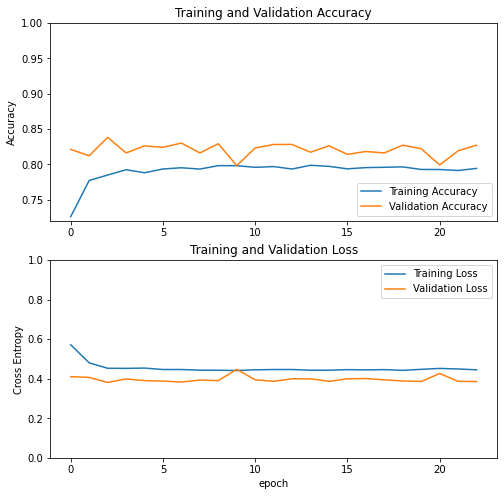

In [ ]:
plot_acc_loss(history)

In [ ]:
# load model from checkpoint with best val loss
resnet = load_model('drive/My Drive/FoodPorn/Models/resnet.h5')

In [ ]:
score = resnet.evaluate(val_dataset, verbose=0)
print(f'Best Validation Loss: {round(score[0], 4)} / Validation Accuracy: {round(score[1], 4)}')

Best Validation Loss: 0.3812 / Validation Accuracy: 0.838


In [ ]:
score = resnet.evaluate(test_dataset, verbose=0)
print(f'Test loss: {round(score[0], 4)} / Test accuracy: {round(score[1], 4)}')

Test loss: 0.3746 / Test accuracy: 0.831


The model saw the lowest loss after only 3 epochs with a validation loss of 0.3812, validation accuracy of 0.8380, test loss of 0.3746, and test accuracy of 0.8310.

# Fine Tuning

In [ ]:
# set model to trainable
resnet.trainable = True

# recompile model after changing trainable status
resnet.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), # use very low learning rate
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

resnet.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
fine_tune_epochs = 20

checkpoint_path = 'drive/My Drive/FoodPorn/Models/resnet_finetune.h5'
mc =  keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)

fine_tune_history = resnet.fit(full_train_ds, 
                     epochs=fine_tune_epochs,
                     validation_data=val_dataset,
                     callbacks=mc)

Epoch 1/20
407/407 [==============================] - ETA: 0s - loss: 0.4125 - accuracy: 0.8142
Epoch 00001: val_loss improved from inf to 0.35446, saving model to drive/My Drive/FoodPorn/Models/resnet_finetune.h5
407/407 [==============================] - 52s 128ms/step - loss: 0.4125 - accuracy: 0.8142 - val_loss: 0.3545 - val_accuracy: 0.8490
Epoch 2/20
407/407 [==============================] - ETA: 0s - loss: 0.3262 - accuracy: 0.8559
Epoch 00002: val_loss improved from 0.35446 to 0.34986, saving model to drive/My Drive/FoodPorn/Models/resnet_finetune.h5
407/407 [==============================] - 50s 122ms/step - loss: 0.3262 - accuracy: 0.8559 - val_loss: 0.3499 - val_accuracy: 0.8580
Epoch 3/20
407/407 [==============================] - ETA: 0s - loss: 0.2299 - accuracy: 0.9028
Epoch 00003: val_loss did not improve from 0.34986
407/407 [==============================] - 46s 114ms/step - loss: 0.2299 - accuracy: 0.9028 - val_loss: 0.3803 - val_accuracy: 0.8420
Epoch 4/20
407/407 

In [ ]:
fine_tune_df = pd.DataFrame(fine_tune_history.history)
fine_tune_df.to_csv('drive/My Drive/FoodPorn/Models/fine_tune_history.csv')

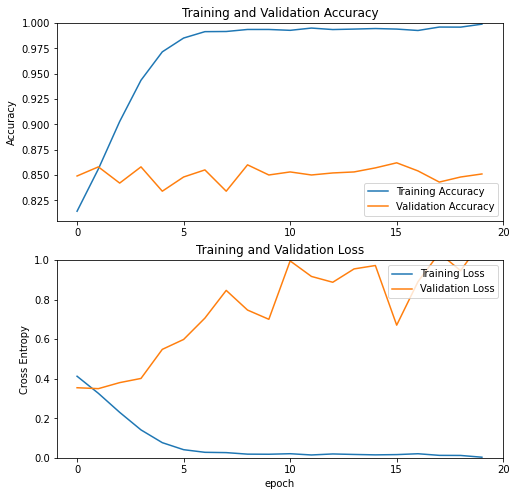

In [ ]:
plot_acc_loss(fine_tune_history)

In [ ]:
# load model from checkpoint with best val loss
fine_tune_resnet = load_model('drive/My Drive/FoodPorn/Models/resnet_finetune.h5')

In [ ]:
score = fine_tune_resnet.evaluate(val_dataset, verbose=0)
print(f'Best Validation Loss: {round(score[0], 4)} / Validation Accuracy: {round(score[1], 4)}')

Best Validation Loss: 0.3499 / Validation Accuracy: 0.858


In [ ]:
score = fine_tune_resnet.evaluate(test_dataset, verbose=0)
print(f'Test Loss: {round(score[0], 4)} / Test Accuracy: {round(score[1], 4)}')

Test Loss: 0.2107 / Test Accuracy: 0.92


Only two epochs of fine tuning was beneficial, but to great results. Validation loss was reduced to 0.3499 and validation accuracy improved to 0.8580. Test accuracy improved from 0.8310 to 0.9200.

# Model Performance

In [ ]:
pred_proba = fine_tune_resnet.predict(test_dataset)

In [ ]:
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

In [ ]:
precision, recall, thresholds = precision_recall_curve(true_labels, pred_proba)
fpr, tpr, roc_threshold = roc_curve(true_labels, pred_proba)
pr_auc = auc(recall, precision)
roc_auc = roc_auc_score(true_labels, pred_proba)

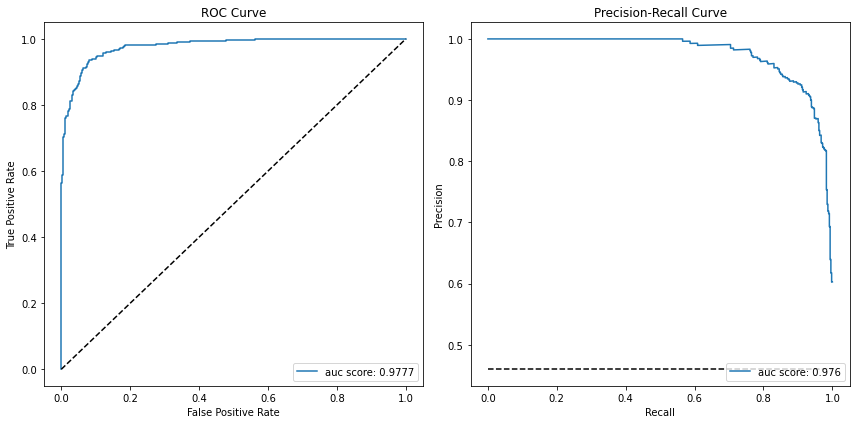

In [ ]:
h_line = len(true_labels[true_labels==1]) / len(true_labels) # horizontal line in precision/recall curve

_ = plt.subplots(figsize=(12,6))
f1 = plt.subplot(1,2,1)
_ = plt.plot(fpr, tpr)
_ = plt.plot([0,1],[0,1], 'k--')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.legend([f'auc score: {round(roc_auc, 4)}'], loc='lower right')

f2 = plt.subplot(1,2,2)
_ = plt.plot(recall, precision)
_ = plt.plot([0, 1], [h_line, h_line], linestyle='--', color='k')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.title('Precision-Recall Curve')
_ = plt.legend([f'auc score: {round(pr_auc, 4)}'], loc='lower right')

plt.tight_layout()

## Decision Threshold

In choosing the decision threshold for the model I propose two options. The first increases the decision threshold to 0.71 to reach a 0.98 precision at the expense of a 0.76 recall. This model would be for food professionals such as advertisers, authors, or chefs who require assurance that their food photographs are of the best quality. I chose not to use perfect precision as this has a recall of 0.57 and has a practical implication of significantly increasing the required number of photos which has an associated cost. The second model reduces the threshold to 0.41 in order to maximize both precision at 0.91 and recall at 0.94 (effectivly maximizing the F1 score). This is for general purpose users such as bloggers or influencers where content creation and volume is more important.

In [ ]:
pred_df = pd.DataFrame({'precision':precision[:-1], 'recall':recall[:-1], 'threshold':thresholds})
pred_df = pred_df.assign(f1 = lambda x : 2 * (x.precision * x.recall) / (x.precision + x.recall))

### Max Precision

In [ ]:
pred_df[pred_df.precision == 1].sort_values(by='recall', ascending=False).head(1)

precision    recall  threshold        f1
503        1.0  0.565217    0.88374  0.722222

### High Precision

In [ ]:
pred_df[pred_df.precision >= 0.98].sort_values(by='recall', ascending=False).head(1)

precision    recall  threshold        f1
405   0.980447  0.763043   0.714223  0.858191

### Maximize F1

In [ ]:
pred_df.sort_values('f1', ascending=False).head(1)

precision    recall  threshold       f1
287   0.905462  0.936957   0.407774  0.92094

### Thresholds

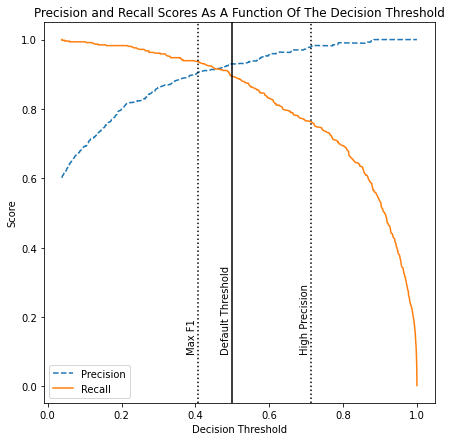

In [ ]:
_ = plt.figure(figsize=(7, 7))
_ = plt.title('Precision and Recall Scores As A Function Of The Decision Threshold')
_ = plt.plot(thresholds, precision[:-1], '--', label='Precision')
_ = plt.plot(thresholds, recall[:-1], '-', label='Recall')
_ = plt.axvline(x=0.5, c='black')
_ = plt.annotate('Default Threshold', xy=(0.47,0.1), rotation=90)
_ = plt.axvline(x=0.407774, c='k', ls=':')
_ = plt.annotate('Max F1', xy=(0.3777,0.1), rotation=90)
_ = plt.axvline(x=0.714223, c='k', ls=':')
_ = plt.annotate('High Precision', xy=(0.6842,0.1), rotation=90)
_ = plt.ylabel('Score')
_ = plt.xlabel('Decision Threshold')
_ = plt.legend(loc='best')

## Classification Report & Confusion Matrix

In [ ]:
# Adjust the decision thresholds  
maxf1_pred = np.where(pred_proba >= 0.407774, 1, 0)
highpr_pred = np.where(pred_proba >= 0.714223, 1, 0)

print('Classification Report - Max F1')
print(classification_report(true_labels, maxf1_pred))

Classification Report - Max F1
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       540
           1       0.91      0.94      0.92       460

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [ ]:
print('Classification Report - High Precision')
print(classification_report(true_labels, highpr_pred))

Classification Report - High Precision
              precision    recall  f1-score   support

           0       0.83      0.99      0.90       540
           1       0.98      0.76      0.86       460

    accuracy                           0.88      1000
   macro avg       0.91      0.88      0.88      1000
weighted avg       0.90      0.88      0.88      1000



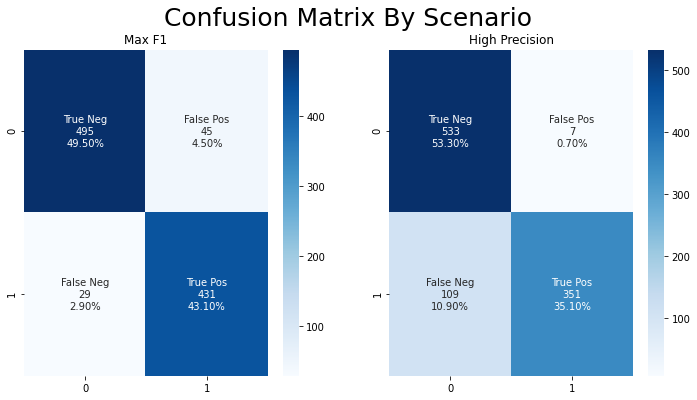

In [ ]:
cmatrix_maxf1 = confusion_matrix(true_labels, maxf1_pred)
cmatrix_highpr = confusion_matrix(true_labels, highpr_pred)

_ = plt.subplots(figsize=(12,6))
_ = plt.subplot(1,2,1)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cmatrix_maxf1.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cmatrix_maxf1.flatten()/np.sum(cmatrix_maxf1)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
_ = sns.heatmap(cmatrix_maxf1, annot=labels, cmap='Blues', fmt='')
_ = plt.title('Max F1')

_ = plt.subplot(1,2,2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cmatrix_highpr.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cmatrix_highpr.flatten()/np.sum(cmatrix_highpr)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
_ = sns.heatmap(cmatrix_highpr, annot=labels, cmap='Blues', fmt='')
_ = plt.title('High Precision')
_ = plt.suptitle("Confusion Matrix By Scenario", size=25)

# Model

In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

# Feature Visualization

Adapted from: https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/visualizing_what_convnets_learn.ipynb

## Set Up

In [ ]:
model = fine_tune_resnet
model = model.get_layer('resnet50')

In [ ]:
# final layer of fine tune resnet50
layer_name = 'conv5_block3_3_conv'

# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [ ]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [ ]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [ ]:

def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [147]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(64):
    #print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("drive/My Drive/FoodPorn/Layer Visualization/resnet_trained.png", stitched_filters)

## Layer Visualization

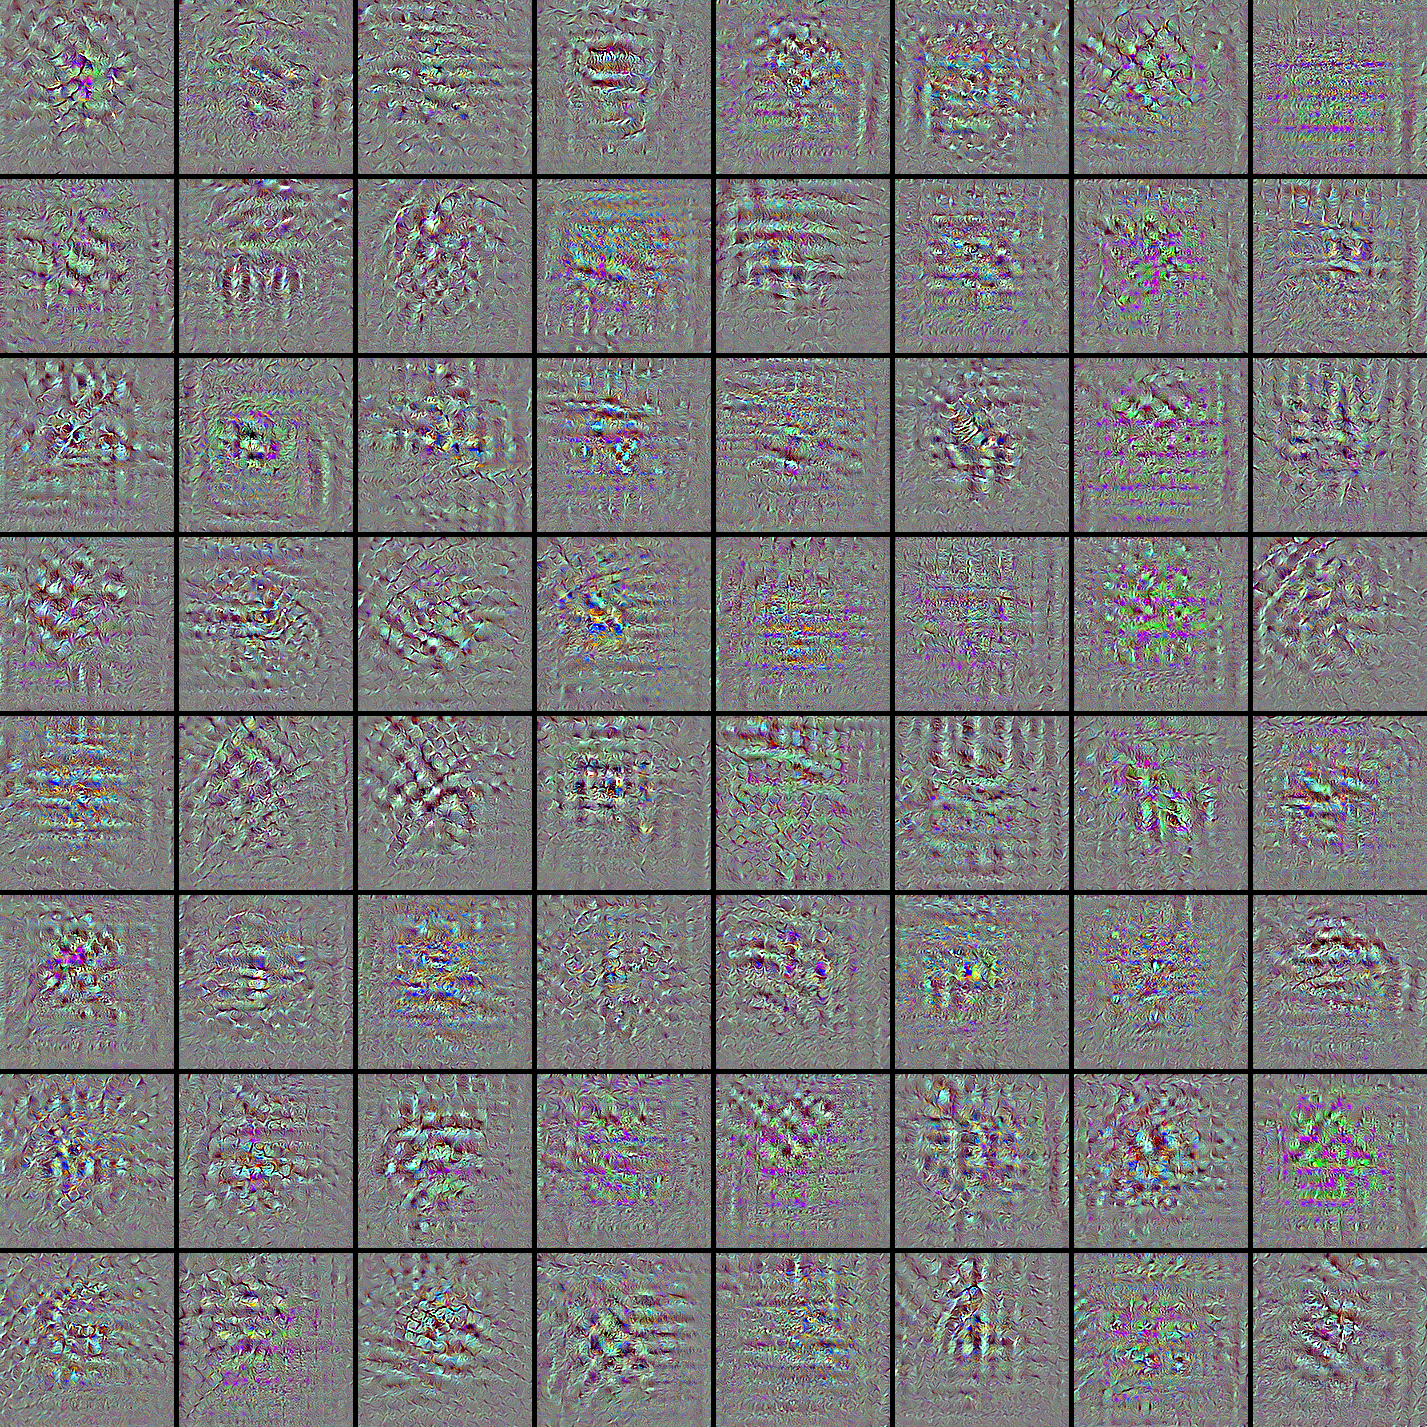

In [148]:
from IPython.display import Image, display

display(Image("drive/My Drive/FoodPorn/Layer Visualization/resnet_trained.png"))

# Next Steps

- Use more images
- try other pretrained networks

In [ ]:
# Transfer Learning: VGG16, InceptionV3, ResNet50
# https://keras.io/guides/transfer_learning/
# https://www.tensorflow.org/tutorials/images/transfer_learning
# https://towardsdatascience.com/how-to-choose-the-best-keras-pre-trained-model-for-image-classification-b850ca4428d4

# keras tuner for selection
# https://www.tensorflow.org/tutorials/keras/keras_tuner
# https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html


#examples 

# https://github.com/risenW/medium_tutorial_notebooks/blob/master/transfer-learning-in-keras-on-dogs-vs-cats.ipynb

#https://medium.com/@1297rohit/transfer-learning-from-scratch-using-keras-339834b153b9
#https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c




# other examples
# https://github.com/ithisted/AmazonImageClassification/tree/master/notebooks
# https://github.com/ithisted/AmazonImageClassification/blob/master/notebooks/6%20-%20ConvNetFilterVisualization.ipynb < ----- this one!
# https://github.com/Gianl-msi/FVC-prediction---Pulmonary-Fibrosis

# https://github.com/Pyligent/food101-image-classification
